# Gridding agricultural census data - HiResIreland

Gridding based on
<https://james-brennan.github.io/posts/fast_gridding_geopandas/>

In [1]:
# import libraries
import os
import itertools
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import shapely
import xarray as xr
import climag.plot_configs as cplt

## Open some gridded climate data

In [2]:
TS_FILE = os.path.join(
    "data", "HiResIreland", "IE", "IE_HiResIreland_COSMO5_EC-EARTH_rcp45.nc"
)

In [3]:
data = xr.open_dataset(TS_FILE, chunks="auto", decode_coords="all")

In [4]:
data

<xarray.Dataset>
Dimensions:       (time: 11323, rlon: 90, rlat: 116, bnds: 2)
Coordinates:
  * time          (time) datetime64[ns] 2040-01-01T10:30:00 ... 2070-12-31T10...
  * rlon          (rlon) float64 -1.68 -1.645 -1.61 -1.575 ... 1.365 1.4 1.435
  * rlat          (rlat) float64 -1.98 -1.945 -1.91 -1.875 ... 1.975 2.01 2.045
    lon           (rlat, rlon) float32 dask.array<chunksize=(116, 90), meta=np.ndarray>
    lat           (rlat, rlon) float32 dask.array<chunksize=(116, 90), meta=np.ndarray>
    height_2m     float32 ...
    spatial_ref   int64 ...
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(11323, 2), meta=np.ndarray>
    rotated_pole  int64 ...
Dimensions without coordinates: bnds
Data variables:
    PET           (time, rlat, rlon) float32 dask.array<chunksize=(7481, 76, 59), meta=np.ndarray>
    PP            (time, rlat, rlon) float32 dask.array<chunksize=(7481, 76, 59), meta=np.ndarray>
    T             (time, rlat, rlon) float32 dask.array<chunksize=(7481, 76, 59), meta=np.ndarray>
    PAR           (time, rlat, rlon) float32 dask.array<chunksize=(7481, 76, 59), meta=np.ndarray>
Attributes: (12/13)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    Conventions:     CF-1.4
    title:           COSMO5_EC-EARTH_rcp45_4km
    experiment_id:   COSMO5_EC-EARTH_rcp45_4km
    realization:     1
    conventionsURL:  http://www.cfconventions.org/
    ...              ...
    references:      http://www.ichec.ie
    creation_date:   2018-05-21 20:31:05
    frequency:       day
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....
    dataset:         IE_HiResIreland_COSMO5_EC-EARTH_rcp45
    comment:         This dataset has been clipped with the Island of Ireland...

In [5]:
# keep only one variable
data = data.drop_vars(names=["PET", "PP", "PAR"])

In [6]:
data

<xarray.Dataset>
Dimensions:       (time: 11323, rlon: 90, rlat: 116, bnds: 2)
Coordinates:
  * time          (time) datetime64[ns] 2040-01-01T10:30:00 ... 2070-12-31T10...
  * rlon          (rlon) float64 -1.68 -1.645 -1.61 -1.575 ... 1.365 1.4 1.435
  * rlat          (rlat) float64 -1.98 -1.945 -1.91 -1.875 ... 1.975 2.01 2.045
    lon           (rlat, rlon) float32 dask.array<chunksize=(116, 90), meta=np.ndarray>
    lat           (rlat, rlon) float32 dask.array<chunksize=(116, 90), meta=np.ndarray>
    height_2m     float32 ...
    spatial_ref   int64 ...
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(11323, 2), meta=np.ndarray>
    rotated_pole  int64 ...
Dimensions without coordinates: bnds
Data variables:
    T             (time, rlat, rlon) float32 dask.array<chunksize=(7481, 76, 59), meta=np.ndarray>
Attributes: (12/13)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    Conventions:     CF-1.4
    title:           COSMO5_EC-EARTH_rcp45_4km
    experiment_id:   COSMO5_EC-EARTH_rcp45_4km
    realization:     1
    conventionsURL:  http://www.cfconventions.org/
    ...              ...
    references:      http://www.ichec.ie
    creation_date:   2018-05-21 20:31:05
    frequency:       day
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....
    dataset:         IE_HiResIreland_COSMO5_EC-EARTH_rcp45
    comment:         This dataset has been clipped with the Island of Ireland...

In [7]:
# copy CRS
crs = data.rio.crs

In [8]:
crs

CRS.from_wkt('GEOGCRS["undefined",BASEGEOGCRS["undefined",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ID["EPSG",6326]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],DERIVINGCONVERSION["Pole rotation (netCDF CF convention)",METHOD["Pole rotation (netCDF CF convention)"],PARAMETER["Grid north pole latitude (netCDF CF convention)",36.5999984741211,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],PARAMETER["Grid north pole longitude (netCDF CF convention)",172.100006103516,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],PARAMETER["North pole grid longitude (netCDF CF convention)",0,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]],CS[ellipsoidal,2],AXIS["longitude",east,ORDER[1],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],AXIS["latitude",north,ORDER[2],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]]')

## Use the gridded data's bounds to generate a gridded vector layer

In [9]:
data.rio.bounds()

(-1.6974999469317746,
 -1.9975000194881274,
 1.452499942163403,
 2.062500076708586)

In [10]:
xmin, ymin, xmax, ymax = data.rio.bounds()
# the difference between two adjacent rotated lat or lon values is the
# cell size
cell_size = float(data["rlat"][1] - data["rlat"][0])

In [11]:
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax + cell_size, cell_size):
    for y0 in np.arange(ymin, ymax + cell_size, cell_size):
        # bounds
        x1 = x0 - cell_size
        y1 = y0 + cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
grid_cells = gpd.GeoDataFrame(grid_cells, columns=["geometry"], crs=crs)

In [12]:
grid_cells.shape

(10856, 1)

In [13]:
grid_cells.head()

,geometry
0,"POLYGON ((-1.73250 -1.99750, -1.73250 -1.96250..."
1,"POLYGON ((-1.73250 -1.96250, -1.73250 -1.92750..."
2,"POLYGON ((-1.73250 -1.92750, -1.73250 -1.89250..."
3,"POLYGON ((-1.73250 -1.89250, -1.73250 -1.85750..."
4,"POLYGON ((-1.73250 -1.85750, -1.73250 -1.82250..."


In [14]:
grid_cells.crs

<Derived Geographic 2D CRS: GEOGCRS["undefined",BASEGEOGCRS["undefined",DATUM[ ...>
Name: undefined
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Coordinate Operation:
- name: Pole rotation (netCDF CF convention)
- method: Pole rotation (netCDF CF convention)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Subset climate data to visualise the cells

In [15]:
data_ = data.sel(time="2041-06-21")

In [16]:
data_

<xarray.Dataset>
Dimensions:       (time: 1, rlon: 90, rlat: 116, bnds: 2)
Coordinates:
  * time          (time) datetime64[ns] 2041-06-21T10:30:00
  * rlon          (rlon) float64 -1.68 -1.645 -1.61 -1.575 ... 1.365 1.4 1.435
  * rlat          (rlat) float64 -1.98 -1.945 -1.91 -1.875 ... 1.975 2.01 2.045
    lon           (rlat, rlon) float32 dask.array<chunksize=(116, 90), meta=np.ndarray>
    lat           (rlat, rlon) float32 dask.array<chunksize=(116, 90), meta=np.ndarray>
    height_2m     float32 ...
    spatial_ref   int64 ...
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    rotated_pole  int64 ...
Dimensions without coordinates: bnds
Data variables:
    T             (time, rlat, rlon) float32 dask.array<chunksize=(1, 76, 59), meta=np.ndarray>
Attributes: (12/13)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    Conventions:     CF-1.4
    title:           COSMO5_EC-EARTH_rcp45_4km
    experiment_id:   COSMO5_EC-EARTH_rcp45_4km
    realization:     1
    conventionsURL:  http://www.cfconventions.org/
    ...              ...
    references:      http://www.ichec.ie
    creation_date:   2018-05-21 20:31:05
    frequency:       day
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....
    dataset:         IE_HiResIreland_COSMO5_EC-EARTH_rcp45
    comment:         This dataset has been clipped with the Island of Ireland...

In [17]:
# find number of grid cells with data
len(data_["T"].values.flatten()[np.isfinite(data_["T"].values.flatten())])

6118

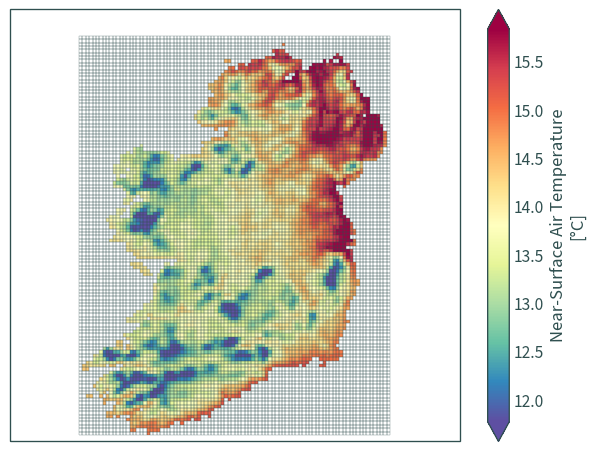

In [18]:
plot_transform = cplt.rotated_pole_transform(data_)
# plt.figure(figsize=(9, 7))
axs = plt.axes(projection=cplt.plot_projection)

# plot data for the variable
data_["T"].plot(
    ax=axs,
    cmap="Spectral_r",
    x="rlon",
    y="rlat",
    robust=True,
    transform=plot_transform
)
grid_cells.to_crs(cplt.plot_projection).boundary.plot(
    ax=axs, color="darkslategrey", linewidth=.2
)

axs.set_title(None)
plt.axis("equal")
plt.tight_layout()
plt.show()

## Drop grid cells without climate data

In [19]:
grid_centroids = {
    "wkt": [],
    "rlon": [],
    "rlat": []
}

for rlon, rlat in itertools.product(
    range(len(data.coords["rlon"])),
    range(len(data.coords["rlat"]))
):
    data__ = data.isel(rlon=rlon, rlat=rlat)

    # ignore null cells
    if not data__["T"].isnull().all():
        grid_centroids["wkt"].append(
            f"POINT ({float(data__['rlon'].values)} "
            f"{float(data__['rlat'].values)})"
        )
        grid_centroids["rlon"].append(float(data__["rlon"].values))
        grid_centroids["rlat"].append(float(data__["rlat"].values))

In [20]:
grid_centroids = gpd.GeoDataFrame(
    grid_centroids,
    geometry=gpd.GeoSeries.from_wkt(grid_centroids["wkt"], crs=crs)
)

In [21]:
grid_centroids.head()

,wkt,rlon,rlat,geometry
0,POINT (-1.6799999475479126 -1.315000057220459),-1.680,-1.315,POINT (-1.68000 -1.31500)
1,POINT (-1.6799999475479126 -1.2799999713897705),-1.680,-1.280,POINT (-1.68000 -1.28000)
2,POINT (-1.6449999809265137 -1.5950000286102295),-1.645,-1.595,POINT (-1.64500 -1.59500)
3,POINT (-1.6449999809265137 -1.315000057220459),-1.645,-1.315,POINT (-1.64500 -1.31500)
4,POINT (-1.6449999809265137 -1.2799999713897705),-1.645,-1.280,POINT (-1.64500 -1.28000)


In [22]:
grid_centroids.shape

(6118, 4)

In [23]:
grid_centroids.crs

<Derived Geographic 2D CRS: GEOGCRS["undefined",BASEGEOGCRS["undefined",DATUM[ ...>
Name: undefined
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Coordinate Operation:
- name: Pole rotation (netCDF CF convention)
- method: Pole rotation (netCDF CF convention)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
grid_cells = gpd.sjoin(grid_cells, grid_centroids.to_crs(grid_cells.crs))

In [25]:
grid_cells.drop(columns=["wkt", "index_right"], inplace=True)

In [26]:
grid_cells.head()

,geometry,rlon,rlat
137,"POLYGON ((-1.69750 -1.33250, -1.69750 -1.29750...",-1.680,-1.315
138,"POLYGON ((-1.69750 -1.29750, -1.69750 -1.26250...",-1.680,-1.280
247,"POLYGON ((-1.66250 -1.61250, -1.66250 -1.57750...",-1.645,-1.595
255,"POLYGON ((-1.66250 -1.33250, -1.66250 -1.29750...",-1.645,-1.315
256,"POLYGON ((-1.66250 -1.29750, -1.66250 -1.26250...",-1.645,-1.280


In [27]:
grid_cells.shape

(6118, 3)

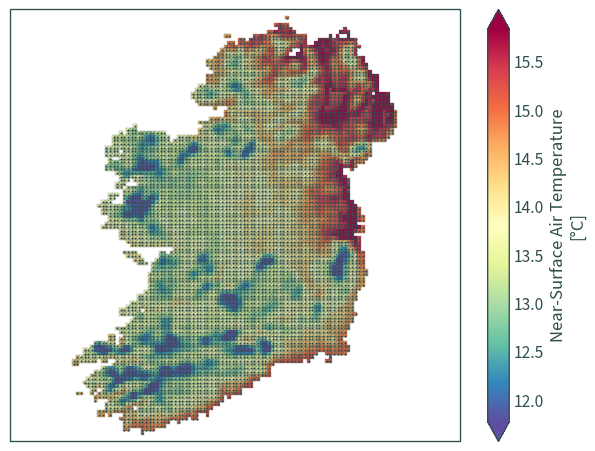

In [28]:
# plt.figure(figsize=(9, 7))
axs = plt.axes(projection=cplt.plot_projection)

# plot data for the variable
data_["T"].plot(
    ax=axs,
    cmap="Spectral_r",
    x="rlon",
    y="rlat",
    robust=True,
    transform=plot_transform
)

grid_cells.to_crs(cplt.plot_projection).plot(
    ax=axs, edgecolor="darkslategrey", facecolor="none", linewidth=.2
)

grid_centroids.to_crs(cplt.plot_projection).plot(
    ax=axs, color="darkslategrey", markersize=.5
)

axs.set_title(None)
plt.axis("equal")
plt.tight_layout()
plt.show()

## Read stocking rate data

In [29]:
stocking_rate = gpd.read_file(
    os.path.join("data", "agricultural_census", "agricultural_census.gpkg"),
    layer="stocking_rate"
)

In [30]:
stocking_rate.crs

<Derived Projected CRS: EPSG:2157>
Name: IRENET95 / Irish Transverse Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore. United Kingdom (UK) - Northern Ireland (Ulster) - onshore.
- bounds: (-10.56, 51.39, -5.34, 55.43)
Coordinate Operation:
- name: Irish Transverse Mercator
- method: Transverse Mercator
Datum: IRENET95
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [31]:
stocking_rate.head()

,ENGLISH,COUNTY,PROVINCE,GUID,total_cattle,total_sheep,total_grass_hectares,electoral_division,WD22CD,WD22NM,ward_2014_name,stocking_rate,geometry
0,TURNAPIN,DUBLIN,Leinster,2ae19629-1cea-13a3-e055-000000000001,0.0,0.0,0.0,"Turnapin, Co.Dublin, 04042",0,0,0,0.000000,"POLYGON ((717716.712 741601.510, 717759.461 74..."
1,DRUMLUMMAN,CAVAN,Ulster,2ae19629-1caa-13a3-e055-000000000001,2673.0,231.0,1249.1,"Drumlumman, Co.Cavan, 32089",0,0,0,1.730446,"POLYGON ((637756.185 787640.988, 637753.646 78..."
2,CASTLEFORE,LEITRIM,Connacht,2ae19629-171c-13a3-e055-000000000001,630.0,0.0,805.9,"Castlefore, Co.Leitrim, 28063",0,0,0,0.625388,"POLYGON ((608196.069 807618.950, 608244.536 80..."
3,RAHONA,CLARE,Munster,2ae19629-1fec-13a3-e055-000000000001,2369.0,0.0,1349.9,"Rahona, Co.Clare, 16101",0,0,0,1.403956,"POLYGON ((484212.068 651795.629, 484231.866 65..."
4,CROSSAKEEL,MEATH,Leinster,2ae19629-1861-13a3-e055-000000000001,4826.0,671.0,2014.1,"Crossakeel, Co.Meath, 11061",0,0,0,1.950201,"POLYGON ((663308.409 776111.796, 663305.294 77..."


In [32]:
stocking_rate.shape

(3917, 13)

In [33]:
stocking_rate["stocking_rate"].max()

5.627624825011666

In [34]:
stocking_rate["stocking_rate"].min()

0.0

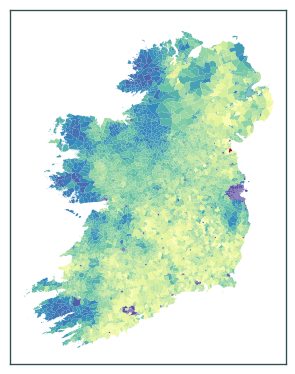

In [35]:
stocking_rate.plot(column="stocking_rate", cmap="Spectral_r")
plt.tick_params(labelbottom=False, labelleft=False)
plt.show()

## Reproject cells to the CRS of the stocking rate data

In [36]:
# use a projected CRS (e.g. 2157) instead of a geographical CRS (e.g. 4326)
grid_cells = grid_cells.to_crs(stocking_rate.crs)

In [37]:
grid_cells.head()

,geometry,rlon,rlat
137,"POLYGON ((417558.169 590305.235, 417549.771 59...",-1.680,-1.315
138,"POLYGON ((417549.771 594200.519, 417541.440 59...",-1.680,-1.280
247,"POLYGON ((421531.348 559152.004, 421522.478 56...",-1.645,-1.595
255,"POLYGON ((421462.259 590312.894, 421453.924 59...",-1.645,-1.315
256,"POLYGON ((421453.924 594208.112, 421445.655 59...",-1.645,-1.280


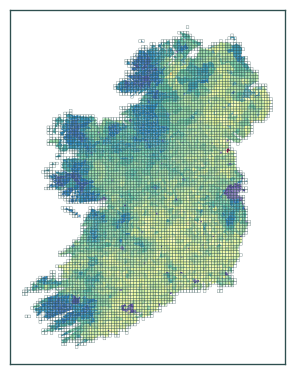

In [38]:
axs = stocking_rate.plot(column="stocking_rate", cmap="Spectral_r")
grid_cells.boundary.plot(color="darkslategrey", linewidth=.2, ax=axs)
axs.tick_params(labelbottom=False, labelleft=False)
plt.show()

## Create gridded stocking rate data

In [42]:
merged = gpd.sjoin(stocking_rate, grid_cells, how="left")

In [43]:
merged.head()

,ENGLISH,COUNTY,PROVINCE,GUID,total_cattle,total_sheep,total_grass_hectares,electoral_division,WD22CD,WD22NM,ward_2014_name,stocking_rate,geometry,index_right,rlon,rlat
0,TURNAPIN,DUBLIN,Leinster,2ae19629-1cea-13a3-e055-000000000001,0.0,0.0,0.0,"Turnapin, Co.Dublin, 04042",0,0,0,0.000000,"POLYGON ((717716.712 741601.510, 717759.461 74...",9143,0.980,0.015
0,TURNAPIN,DUBLIN,Leinster,2ae19629-1cea-13a3-e055-000000000001,0.0,0.0,0.0,"Turnapin, Co.Dublin, 04042",0,0,0,0.000000,"POLYGON ((717716.712 741601.510, 717759.461 74...",9261,1.015,0.015
1,DRUMLUMMAN,CAVAN,Ulster,2ae19629-1caa-13a3-e055-000000000001,2673.0,231.0,1249.1,"Drumlumman, Co.Cavan, 32089",0,0,0,1.730446,"POLYGON ((637756.185 787640.988, 637753.646 78...",6795,0.280,0.435
1,DRUMLUMMAN,CAVAN,Ulster,2ae19629-1caa-13a3-e055-000000000001,2673.0,231.0,1249.1,"Drumlumman, Co.Cavan, 32089",0,0,0,1.730446,"POLYGON ((637756.185 787640.988, 637753.646 78...",6913,0.315,0.435
1,DRUMLUMMAN,CAVAN,Ulster,2ae19629-1caa-13a3-e055-000000000001,2673.0,231.0,1249.1,"Drumlumman, Co.Cavan, 32089",0,0,0,1.730446,"POLYGON ((637756.185 787640.988, 637753.646 78...",6678,0.245,0.470


In [44]:
merged.shape

(22237, 16)

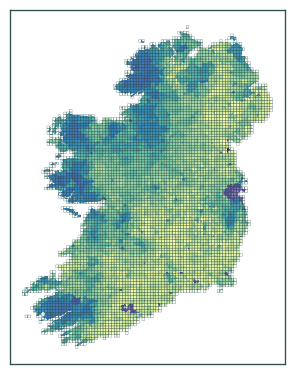

In [45]:
axs = merged.plot(column="stocking_rate", cmap="Spectral_r")
grid_cells.boundary.plot(color="darkslategrey", linewidth=.2, ax=axs)
axs.tick_params(labelbottom=False, labelleft=False)
plt.show()

In [47]:
# compute stats per grid cell, use the mean stocking rate
dissolve = merged[["stocking_rate", "index_right", "geometry"]].dissolve(
    by="index_right", aggfunc=np.mean
)

In [48]:
dissolve.shape

(6116, 2)

In [49]:
dissolve.head()

,geometry,stocking_rate
index_right,,
137,"MULTIPOLYGON (((421214.433 590565.624, 421215....",0.917024
138,"MULTIPOLYGON (((421214.433 590565.624, 421215....",0.917024
247,"MULTIPOLYGON (((424582.660 560554.883, 424573....",0.763591
255,"MULTIPOLYGON (((421214.433 590565.624, 421215....",0.917024
256,"MULTIPOLYGON (((421214.433 590565.624, 421215....",0.917024


In [50]:
len(dissolve.index.unique())

6116

In [51]:
# merge with cell data
grid_cells.loc[dissolve.index, "sr"] = dissolve["stocking_rate"].values

In [52]:
grid_cells.shape

(6118, 4)

In [53]:
grid_cells.head()

,geometry,rlon,rlat,sr
137,"POLYGON ((417558.169 590305.235, 417549.771 59...",-1.680,-1.315,0.917024
138,"POLYGON ((417549.771 594200.519, 417541.440 59...",-1.680,-1.280,0.917024
247,"POLYGON ((421531.348 559152.004, 421522.478 56...",-1.645,-1.595,0.763591
255,"POLYGON ((421462.259 590312.894, 421453.924 59...",-1.645,-1.315,0.917024
256,"POLYGON ((421453.924 594208.112, 421445.655 59...",-1.645,-1.280,0.917024


In [55]:
len(grid_cells["geometry"].unique())

6118

In [56]:
grid_cells["sr"].max()

3.3106305957064275

In [57]:
grid_cells["sr"].min()

0.0

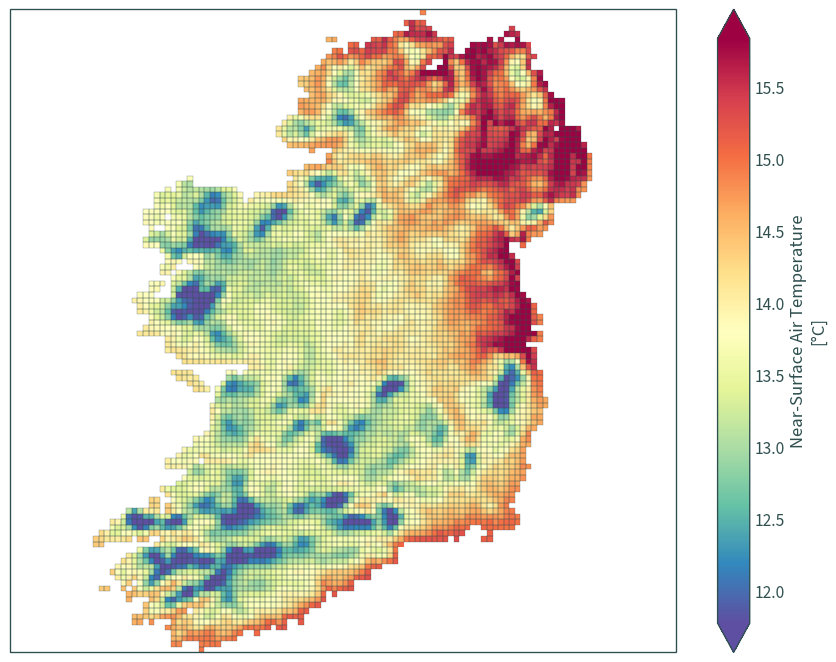

In [58]:
plt.figure(figsize=(9, 7))
axs = plt.axes(projection=cplt.plot_projection)

# plot data for the variable
data_["T"].plot(
    ax=axs,
    cmap="Spectral_r",
    x="rlon",
    y="rlat",
    robust=True,
    transform=plot_transform
)

grid_cells.to_crs(cplt.plot_projection).plot(
    column="sr", ax=axs, edgecolor="darkslategrey",
    facecolor="none", linewidth=.2
)

axs.set_title(None)
plt.axis("equal")
plt.tight_layout()
plt.show()

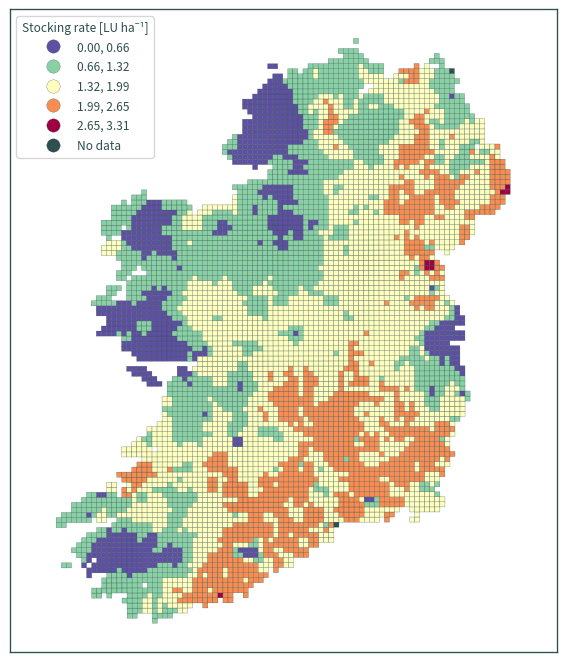

In [59]:
axs = grid_cells.plot(
    column="sr", cmap="Spectral_r", scheme="equal_interval",
    edgecolor="darkslategrey", linewidth=.2, figsize=(6, 7),
    legend=True, legend_kwds={
        "loc": "upper left", "fmt": "{:.2f}",
        "title": "Stocking rate [LU ha⁻¹]"
    },
    missing_kwds={
        "color": "darkslategrey", "edgecolor": "darkslategrey",
        "label": "No data"
    }
)
for legend_handle in axs.get_legend().legend_handles:
    legend_handle.set_markeredgewidth(.2)
    legend_handle.set_markeredgecolor("darkslategrey")
axs.tick_params(labelbottom=False, labelleft=False)
plt.axis("equal")
plt.tight_layout()
plt.show()

In [61]:
# fill no data with min value
grid_cells["sr"] = grid_cells["sr"].fillna(grid_cells["sr"].min())

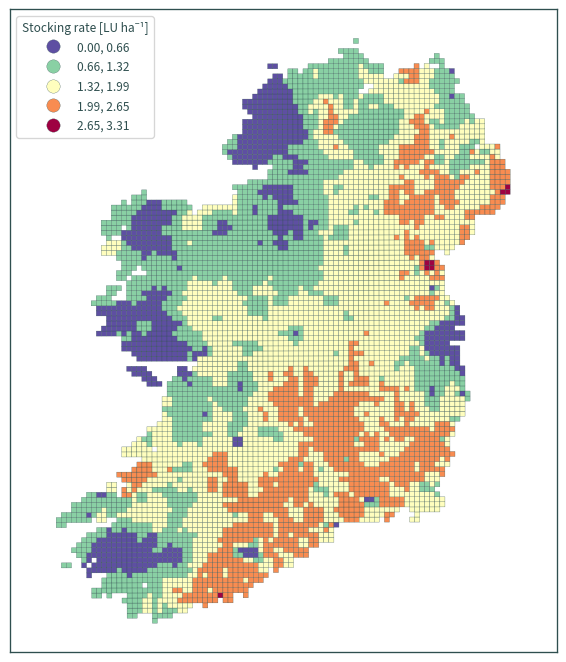

In [62]:
axs = grid_cells.plot(
    column="sr", cmap="Spectral_r", scheme="equal_interval",
    edgecolor="darkslategrey", linewidth=.2, figsize=(6, 7),
    legend=True, legend_kwds={
        "loc": "upper left", "fmt": "{:.2f}",
        "title": "Stocking rate [LU ha⁻¹]"
    },
    missing_kwds={
        "color": "darkslategrey", "edgecolor": "darkslategrey",
        "label": "No data"
    }
)
for legend_handle in axs.get_legend().legend_handles:
    legend_handle.set_markeredgewidth(.2)
    legend_handle.set_markeredgecolor("darkslategrey")
axs.tick_params(labelbottom=False, labelleft=False)
plt.axis("equal")
plt.tight_layout()
plt.show()

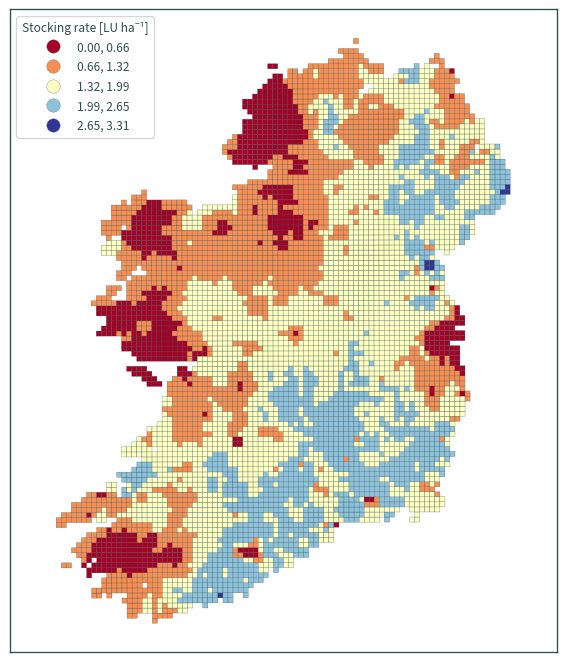

In [7]:
axs = grid_cells.plot(
    column="sr", cmap="RdYlBu", scheme="equal_interval",
    edgecolor="darkslategrey", linewidth=.2, figsize=(6, 7),
    legend=True, legend_kwds={
        "loc": "upper left", "fmt": "{:.2f}",
        "title": "Stocking rate [LU ha⁻¹]"
    },
    missing_kwds={
        "color": "darkslategrey", "edgecolor": "darkslategrey",
        "label": "No data"
    }
)
for legend_handle in axs.get_legend().legend_handles:
    legend_handle.set_markeredgewidth(.2)
    legend_handle.set_markeredgecolor("darkslategrey")
axs.tick_params(labelbottom=False, labelleft=False)
plt.axis("equal")
plt.tight_layout()
plt.show()

In [63]:
grid_cells.to_file(
    os.path.join("data", "ModVege", "params.gpkg"), layer="hiresireland"
)